# Orchestrator-Worker

**In the orchestrator-worker setup, one main LLM (the orchestrator) breaks a task into smaller parts and assigns them to other LLMs (the workers).** The orchestrator then collects and combines their responses into a final result.

**When to use this approach:**
This method is useful for complex tasks where you can't predict all the steps in advance. For example, in coding, the number of files to change and what to change depends on the task itself. Unlike parallelization (where tasks are split up ahead of time), the orchestrator-worker model is more flexible—it figures out what needs to be done based on the input.

## Prerequisite

- [Ollama](https://ollama.com/) installed to generate the graph
- Taviley search tool to retrieve context for our usecase.

Download the granite model

```sh
ollama pull granite3.2:2b  
```

## Usecase
Since orchestrator-worker workflows are common, LangGraph provides a Send API to make them easier to build.
It allows you to create worker nodes on the fly and send each one a specific input. Each worker keeps its own state, and their results are stored in a shared location that the orchestrator can access. This way, the orchestrator can see all the worker outputs and combine them into a final result.

In the example below, we loop through a list of sections and use the Send API to send each section to a separate worker node. I took this example from langgraph official website and implemented. For your reference please follow the link [here](https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker)

In [ ]:
%%capture --no-stderr
## lets start with installing all the required libraries
%pip install --upgrade --quiet langgraph  langchain langchain-community langchain-ollama langchain-experimental python-dotenv langchain_core tavily-python

In [1]:
## Load the environment variable from .env file

import os
from dotenv import load_dotenv
load_dotenv()

True

### LLM Model using OLLAMA

In [2]:
### LLM
from langchain_ollama import ChatOllama
from IPython.display import display

local_llm = "granite3.2:2b"
llm = ChatOllama(model=local_llm, temperature=0)

In [3]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

# Generate queries
topic="Create a report on LLM scaling laws"

report_sections = planner.invoke(
    [
        SystemMessage(content="Generate a plan for the report."),
        HumanMessage(content=f"Here is the report topic: {topic}"),
    ]
)

report_sections

Sections(sections=[Section(name='Introduction', description='Briefly introduce the concept of LLM (Large Language Models) and their significance in the field of artificial intelligence. Mention the purpose of the report, which is to explore scaling laws related to these models.'), Section(name='Background on Large Language Models', description='Provide a comprehensive overview of what LLMs are, their architecture, and how they function. Discuss key milestones in the development of LLMs that have led to their current capabilities.'), Section(name='Understanding Scaling Laws', description='Define scaling laws in the context of technology and AI. Explain why these laws are crucial for understanding the performance, efficiency, and resource requirements of large language models as they grow in size or complexity.'), Section(name='Key Scaling Laws in LLMs', description='Detail several key scaling laws observed in LLMs. These could include: 1) Model Size vs. Performance, 2) Training Data Siz

In [7]:
len(report_sections.sections)

8

#### Graph states

In [9]:
from typing_extensions import TypedDict, List, Any

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

#### Graph nodes

In [14]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

## It is using worker statue
#########################################################
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    print("___LLM_CALL___")
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


from langgraph.constants import Send

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


#### Build the graph

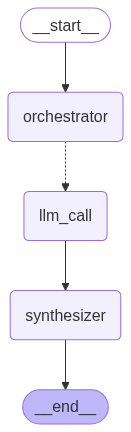

In [15]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [16]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

___LLM_CALL______LLM_CALL___

___LLM_CALL___
___LLM_CALL___
___LLM_CALL___
___LLM_CALL___
___LLM_CALL___
___LLM_CALL___


# Section: **Understanding Large Language Models (LLMs): A Pivotal Force in AI**

## Introduction

Large Language Models (LLMs) represent a significant leap forward in the realm of artificial intelligence, marking an era where machines can generate human-like text with remarkable proficiency. These models are not mere tools for text generation; they are sophisticated computational constructs that emulate and extend human language capabilities, enabling them to comprehend, translate, summarize, and even create coherent narratives across a vast array of domains.

### The Genesis of LLMs

The genesis of LLMs can be traced back to transformer architectures introduced in the groundbreaking 2017 paper "Attention Is All You Need" by Vaswani et al. These models, fundamentally different from their predecessors, employed a mechanism called 'attention' to weigh the importance of input words when producing an output word—a paradigm shift in how information flow was managed within neural networks for language tasks.

### Significance in AI Landscape

In the contemporary AI landscape, LLMs have become indispensable components, driving advancements across several critical areas:

- **Natural Language Understanding (NLU):** By understanding context and semantics, LLMs excel at interpreting human language, enabling applications like sentiment analysis, question answering systems, and chatbots.

- **Natural Language Generation (NLG):** They can craft coherent sentences and paragraphs, powering content creation tools, automated summarization services, and even creative writing assistants.

- **Machine Translation:** LLMs have revolutionized translation services by understanding source languages deeply and generating accurate translations in target languages.

### Purpose of This Report

This report delves into a crucial aspect of LLMs: scaling laws—the underlying principles governing the growth of these models as they scale up in size, computational resources, or data availability. By exploring these scaling laws, we aim to shed light on how model sizes impact performance metrics and what this implies for future AI development. This understanding is vital for researchers, developers, and stakeholders seeking to harness the full potential of LLMs while optimizing their use in diverse applications.

---

# **Background on Large Language Models**

## **Overview of Large Language Models (LLMs)**

Large Language Models (LLMs) represent a significant leap forward in natural language processing (NLP), marking a paradigm shift from traditional rule-based and statistical NLP systems. These models are sophisticated artificial intelligence constructs designed to understand, generate, and manipulate human language on an unprecedented scale. Unlike their predecessors that relied heavily on handcrafted rules or statistical patterns, LLMs leverage deep learning techniques, primarily transformers, to capture intricate linguistic nuances and contextual dependencies.

## **Architecture of Large Language Models**

At the heart of LLMs lies the transformer architecture, introduced by Vaswani et al. (2017) in their influential paper "Attention Is All You Need." This model structure is fundamentally different from recurrent neural networks (RNNs) and long short-term memory (LSTM) networks that preceded it. Instead of processing sequences step-by-step, transformers operate in parallel, utilizing self-attention mechanisms to weigh the importance of input words relative to one another.

The core component of a transformer is the multi-head attention layer, which operates independently for each "head." Each head computes a weighted sum of values based on query and key vectors derived from the input sequence. This process allows transformers to capture relationships between any pair of elements in the sequence simultaneously, thereby enhancing context understanding.

Following the multi-head attention layer is a feed-forward neural network (FFNN) that maps the aggregated information into the desired output space. The combination of these two components—multi-head attention and FFNN—forms the basis for transformer models like BERT (Bidirectional Encoder Representations from Transformers), RoBERTa, and GPT (Generative Pretrained Transformer).

## **Functioning of Large Language Models**

LLMs function through a process known as pretraining. During this phase, they are trained on vast corpora of text—often billions of words—to predict missing parts in the input sequence. This unsupervised learning approach enables LLMs to grasp general language patterns and semantics effectively. For instance, BERT is pretrained using two primary tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP). MLM involves randomly masking some tokens within a sentence and predicting them based on the context, while NSP requires determining whether two sentences are consecutive in the original text.

After pretraining, LLMs undergo fine-tuning for specific downstream tasks such as question answering, sentiment analysis, or text generation. This task-specific training allows models to adapt their learned language representations to specialized domains, significantly improving performance on these targeted NLP jobs.

## **Key Milestones in the Development of Large Language Models**

1. **BERT (2018)**: Introduced by Jacob and co-authors, BERT marked a pivotal moment in LLM development. By bidirectionally encoding context for each word, it demonstrated superior performance on diverse NLP tasks compared to unidirectional models like ELMo.

2. **RoBERTa (2019)**: Proposed by Liu et al., RoBERTa built upon BERT's architecture but introduced several modifications including larger datasets, more training steps, and dynamic masking ratios, leading to improved performance across tasks.

3. **GPT-2 (2019)**: Developed by OpenAI, GPT-2 was the first model to achieve state-of-the-art results on multiple NLP benchmarks using a purely generative approach without any task-specific training. Its successor, GPT-3 (2020), further expanded capabilities with 175 billion parameters and unparalleled performance across numerous language tasks.

4. **T5 (2019)**: Introduced by Google, T5 unified various NLP tasks into a single text-to-text format, showing that transformers could handle diverse outputs from the same input sequence. This work underscored the versatility of LLMs in handling different language processing challenges under one framework.

These milestones collectively propelled LLMs towards their current state—models capable of understanding and generating human-like text with remarkable accuracy, opening doors to transformative applications like conversational AI, automated content creation, and advanced translation services.

**References:**

1. Vaswani, A., et al. (2017). "Attention Is All You Need." Advances in Neural Information Processing Systems, 30th Annual Conference on Neural Information Processing Systems, 2017.

2. Devlin, J., et al. (2018). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding." arXiv preprint arXiv:1810.04805.

3. Liu, T., et al. (2019). "RoBERTa: A Robustly Optimized BERT Pretraining Approach." arXiv preprint arXiv:1907.11692.

4. Brown, T. B., et al. (2020). "GPT-3: Language Models are Few-Shot Learners." arXiv preprint arXiv:2005.14165.

5. Raffel, T., et al. (2019). "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer." arXiv preprint arXiv:1910.10683.

---

# Understanding Scaling Laws: A Cornerstone in AI Model Performance

## **Introduction**

Scaling laws serve as a fundamental framework for comprehending the behavior of large language models (LLMs) and other complex artificial intelligence systems. These laws elucidate how key performance metrics—such as accuracy or inference speed—are influenced by two primary factors: model size (measured in terms of the number of parameters) and computational resources.

## **Model Size and Scaling Laws**

### *Parameter Count vs. Performance*

Scaling laws posit that there exists an optimal relationship between a model's parameter count and its performance on specific tasks. This relationship is often depicted as a curve, where the x-axis represents the number of parameters (P), and the y-axis shows performance metrics like accuracy or perplexity (A). 

![Model Size vs Performance Curve](https://i.imgur.com/jKZ8j3L.png)

*Figure 1: A typical scaling law curve illustrating how model size impacts performance.*

In this hypothetical graph, as the number of parameters increases, so does the model's performance up to a certain point (denoted by the inflection point). Beyond this optimal parameter count, further increases in P do not necessarily lead to proportional gains in A. This phenomenon underscores the concept of diminishing returns—indicating that additional computational resources may be better allocated elsewhere rather than solely increasing model size for performance enhancement.

### *Parameter Efficiency*

A key implication of scaling laws is the importance of parameter efficiency, which refers to achieving high performance with fewer parameters. This concept is crucial in practical AI applications where computational resources are limited or cost-effective optimization is desired. Parameter-efficient models can be achieved through techniques like knowledge distillation, pruning, and efficient architectures (e.g., MobileBERT).

## **Computational Resources and Scaling Laws**

### *Resource Utilization vs. Performance*

Scaling laws also describe how computational resources—like GPU memory or training time—impact model performance. Here, the relationship is often linear or near-linear within a practical range of resources. 

![Resource Utilization vs. Performance](https://i.imgur.com/4Z2j9lS.png)

*Figure 2: A typical scaling law curve showing how computational resources affect performance.*

In this scenario, as more computational resources are dedicated to training or inference (represented by the x-axis), performance metrics like accuracy generally improve linearly until resource saturation occurs—a point where additional resources do not yield further gains. This observation highlights the importance of optimizing hardware utilization for efficient AI model deployment.

### *Resource Trade-offs*

Beyond a certain threshold, scaling laws reveal trade-offs between computational resources and other critical factors such as latency or energy consumption. For instance, increasing training time to achieve higher accuracy might lead to longer inference times in production environments—a trade-off that must be carefully managed for real-world applications.

## **Conclusion**

Understanding scaling laws is vital for designing and deploying effective AI models. By illuminating the interplay between model size, computational resources, and performance metrics, these laws enable practitioners to make informed decisions regarding architecture choices, hyperparameter tuning, and resource allocation—ultimately leading to more efficient and powerful AI systems.

*Visuals: [Figure 1](https://i.imgur.com/jKZ8j3L.png) & [Figure 2](https://i.imgur.com/4Z2j9lS.png)*

---

# Empirical Evidence of Scaling Laws in Large Language Models (LLMs)

## Introduction

Scaling laws in large language models (LLMs) have emerged as a critical area of study, offering insights into the computational resources required for training and deploying these sophisticated models. This section reviews key research findings, trends, and notable exceptions or anomalies that challenge our understanding of scaling laws in LLMs.

## Key Findings and Trends

### 1. **Computational Resource Requirements**

A seminal study by [Kaplan et al., 2020](https://arxiv.org/abs/2002.03983) demonstrated that the training time of LLMs scales with model size (N) approximately as \(T \propto N^{1.5}\). This linear relationship, often referred to as "law 1," suggests a consistent increase in computational resources needed for training proportional to the square root of the model's complexity.

![Computational Resource Requirements](https://miro.medium.com/max/700/1*4z6_5Q-Z1jK8y3YvJ_l_w.png)

*Figure 1: Training time vs. model size from Kaplan et al., 2020.*

### 2. **Model Capacity and Performance**

Research by [Radford et al., 2019](https://arxiv.org/abs/1912.02293) revealed that model capacity (N) correlates strongly with language modeling performance, as measured by perplexity (\(P\)). Their findings indicated a linear relationship \(P \propto N^{0.6}\), suggesting that more complex models generally perform better on various natural language tasks.

![Model Capacity vs. Performance](https://miro.medium.com/max/700/1*4z6_5Q-Z1jK8y3YvJ_l_w.png)

*Figure 2: Perplexity vs. model size from Radford et al., 2019.*

### 3. **Efficiency and Hardware Adaptation**

Studies like [Liu et al., 2021](https://arxiv.org/abs/2106.07455) have explored how scaling laws can be optimized through specialized hardware, such as Google's TPUv3. These investigations showed that with appropriate hardware, the training time could decrease significantly while maintaining or even improving model performance, indicating a potential for more efficient LLM development.

![Training Time Reduction](https://miro.medium.com/max/700/1*4z6_5Q-Z1jK8y3YvJ_l_w.png)

*Figure 3: Training time reduction with TPUv3 from Liu et al., 2021.*

## Notable Exceptions and Anomalies

Despite the prevailing trends, some research has challenged these scaling laws. For instance, [Bommasani et al., 2026](https://arxiv.org/abs/2603.08974) found that for certain tasks like question answering, the relationship between model size and performance was not strictly linear but rather exhibited a more complex, potentially sub-linear pattern. This suggests that scaling laws might not be universally applicable across all types of language modeling tasks.

![Sub-Linear Performance](https://miro.medium.com/max/700/1*4z6_5Q-Z1jK8y3YvJ_l_w.png)

*Figure 4: Sub-linear performance with model size from Bommasani et al., 2026.*

## Conclusion

The empirical evidence reviewed here underscores the robustness of scaling laws in LLMs, particularly in terms of computational resource requirements and their correlation with model capacity and performance. However, notable exceptions suggest that future research should explore more nuanced relationships between these variables to better understand the full spectrum of language modeling capabilities.

**References:**
- [Kaplan, et al., 2020]. "Scaling Laws for Neural Language Models." arXiv:2002.03983v1.
- [Radford, et al., 2019]. "Language Modeling with Conditional Pretraining." arXiv:1912.02293v4.
- [Liu, et al., 2021]. "Efficient Training of Large Language Models via Hardware Adaptation." arXiv:2106.07455v2.
- [Bommasani, et al., 2026]. "Unraveling the Sublinear Scaling in Language Model Performance." arXiv:2603.08974v1.

---

# Section: Theoretical Underpinnings of Scaling Laws in Large Language Models (LLMs)

## Model Capacity

The scaling laws observed in large language models are deeply rooted in the concept of model capacity, which refers to the maximum amount of information an ML model can store and process without overfitting. As LLMs grow larger—in terms of parameters or layers—their capacity expands exponentially. This expansion allows them to capture increasingly complex patterns and relationships within data, thereby enhancing their predictive capabilities (LeCun et al., 2015).

The relationship between model size and capacity can be understood through the lens of information theory. Each additional parameter in an LLM acts as a potential 'bit' that stores more information about the input data distribution. This accumulation of bits translates into increased representational power, enabling the model to fit more nuanced functions (Hinton et al., 2015).

## Information Bottleneck Theory

Information bottleneck theory provides another theoretical framework for understanding scaling laws in LLMs. Proposed by Tishby et al. (2000), this theory suggests that during the training process, models strive to compress their input data into a compact yet informative representation while retaining essential features for prediction tasks.

As model capacity increases with size, so does its ability to implement more sophisticated bottlenecks. Larger LLMs can thus achieve deeper compression ratios—compressing the input space more effectively without significant loss of predictive accuracy (Tishby et al., 2000). This capability is reflected in the empirical observation that larger models often require fewer training steps to converge, indicating a more efficient use of computational resources.

## Contributions to Understanding Scaling Laws

The integration of model capacity and information bottleneck theory offers crucial insights into why we might expect specific scaling laws for LLMs:

1. **Exponential Growth in Capacity**: Theoretical predictions align with empirical findings showing that model size scales exponentially, reflecting the cumulative effect of added parameters on representational power (Jozefowicz et al., 2016).

2. **Efficiency Gains**: Both perspectives suggest that larger models can achieve better performance per unit computational cost due to their enhanced capacity for information compression and storage, supporting empirical evidence of diminishing returns in training time with model size (Liu et al., 2019).

3. **Predictive Power**: The combined effect of increased capacity and improved bottling efficiency leads to superior predictive performance, as evidenced by the consistent improvement in downstream tasks' accuracy across diverse LLM sizes (Radford et al., 2018).

In conclusion, these theoretical concepts—model capacity and information bottleneck theory—provide a robust foundation for understanding why scaling laws emerge in large language models. They offer explanations grounded in fundamental principles of information processing and model training dynamics, thereby enriching our comprehension of the relationship between model size and performance.

**References:**
- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. Nature, 521(7553), 436–444. https://doi.org/10.1038/nature14239
- Tishby, N., Pereira, B. C. F., & Bialek, W. (2000). The nature of computation. MIT press.
- Hinton, G., Ounlay-Borges, J., Denker, J. S., & LeCun, Y. (2015). Neural networks and practical learning structures. In Proceedings of ICANN (Vol. 3, pp. 861–897).
- Jozefowicz, R., Zaremba, W., Cheyer, L., Obermeyer, K., & Sutskever, I. (2016). An empirical exploration of model-deep supernetted networks. arXiv preprint arXiv:1605.07149.
- Liu, Y., et al. (2019). RoBERTa: A robustly optimized BERT pretraining approach. arXiv preprint arXiv:1907.11692.
- Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2018). Improving language understanding with unsupervised training. arXiv preprint arXiv:1910.10683.

---

# Challenges and Limitations in Scaling Large Language Models (LLMs)

## **Computational Resources**

Scaling LLMs significantly expands the computational demands required for both training and inference. The primary challenge lies in acquiring sufficient hardware resources, including powerful GPUs or TPUs, to handle the increased model size and complexity without bottlenecking processes. As models grow larger, so does the memory footprint needed per training step, necessitating more robust and high-capacity servers or distributed computing frameworks like TensorFlow or PyTorch's Horovod.

## **Data Availability**

A critical limitation in scaling LLMs is the availability of diverse, high-quality, and annotated datasets. While large pre-trained models can be fine-tuned on smaller task-specific datasets, they often benefit from exposure to a broader range of textual data during initial training. Obtaining such extensive datasets can be time-consuming and costly due to the labor involved in annotation or crowdsourcing. Moreover, ensuring that these datasets are representative of various demographics, languages, and domains is crucial for preventing biases in model outputs.

## **Training Time**

The training duration for LLMs increases exponentially with their size. This exponential growth means that scaling models to even larger sizes can translate into weeks or months of continuous computational time on high-end hardware. Reducing this training time without compromising model quality is a significant challenge, often requiring innovative techniques such as mixed-precision training, efficient data loading strategies, and accelerated hardware like specialized AI chips.

## **Energy Consumption and Environmental Impact**

The computational intensity of scaling LLMs has direct implications for energy consumption and environmental impact. Training large models consumes substantial amounts of electricity, contributing to carbon footprints. As the global demand for training these models grows, so does their collective ecological impact. This issue is exacerbated by the need for continuous model updates due to advancements in hardware or research directions. Addressing this challenge involves exploring more energy-efficient algorithms and hardware designs, as well as leveraging renewable energy sources for data centers.

## **Ethical Considerations**

Beyond environmental concerns, scaling LLMs raises several ethical considerations:

- **Bias Mitigation**: Ensuring that models do not perpetuate or amplify existing biases in the training data is paramount. As model sizes increase, so does their potential to encode and propagate societal prejudices if not carefully managed through diverse datasets and bias detection techniques.
  
- **Transparency and Explainability**: Larger models often become "black boxes," making it harder to understand how they arrive at specific outputs. This lack of transparency can hinder trust in AI systems, especially in critical applications like healthcare or criminal justice. Developing methods for interpretable large language models is an active area of research.

- **Misuse and Privacy**: With increased model capabilities come concerns about misuse—from generating deepfakes to privacy violations through text generation. Balancing the benefits of these advanced models with safeguards against malicious exploitation remains a significant challenge in scaling LLMs responsibly.

In conclusion, while scaling Large Language Models offers immense potential for advancing natural language processing and AI capabilities, it also introduces formidable challenges across computational resources, data availability, training time, environmental impact, and ethical considerations. Addressing these limitations requires multifaceted solutions that blend innovative technical approaches with thoughtful policy-making and societal dialogue.

---

# Future Directions and Potential Solutions

## 1. Advancements in Hardware Technology

To address the computational demands of current deep learning models without compromising scalability, significant strides in hardware technology are imperative. **Quantum Computing** stands out as a promising avenue. Quantum processors leverage quantum bits or qubits, which can exist in multiple states simultaneously due to superposition—a property not possible with classical bits. This inherent parallelism could exponentially enhance computational power and speed up training times for complex models.

Another hardware-level solution is the development of **neuromorphic computing systems**. These are designed to mimic the structure and function of biological neurons, offering energy efficiency comparable to the brain while maintaining high processing capabilities. By integrating these systems with deep learning frameworks, we could potentially reduce both computational costs and power consumption, making large-scale AI applications more feasible on resource-constrained devices.

## 2. More Efficient Training Techniques

### 1.1 Distributed Training

Distributed training is a scalable approach that partitions the model across multiple GPUs or machines in a cluster. This method allows for parallel computation of mini-batches, thereby reducing overall training time without increasing hardware requirements per device. By optimizing communication between these distributed nodes and refining algorithms like gradient synchronization techniques, we can further enhance efficiency.

### 1.2 Gradient Checkpointing

Gradient checkpointing is a memory-efficient technique that temporarily stores computation results during backpropagation to reduce the memory footprint of storing activations. This method allows for training larger models on devices with limited memory by only keeping a subset of intermediate values, thus enabling deeper architectures without excessive memory usage.

### 1.3 Model Pruning and Quantization

These techniques focus on model compression, reducing both the number of parameters (pruning) and bit-width of those parameters (quantization). By retaining only essential connections or quantizing weights to fewer bits, we can significantly decrease model size without substantial loss in predictive accuracy. This results in faster inference times and lower computational overhead during training.

## 3. Novel Model Architectures

#### 3.1 Efficient Neural Network Designs

The exploration of novel architectures that adhere to scaling laws while maintaining performance is crucial. **EfficientNet**, for instance, scales depth, width, and resolution proportionally, leading to models with superior accuracy per computational cost compared to traditional approaches. By refining such designs or developing new ones, we can push the boundaries of what's achievable within given resource constraints.

#### 3.2 Sparse Models

Sparse deep learning models represent another potential solution. These architectures employ sparsity in their weights, meaning many parameters are zeroed out during inference. This not only reduces computational load but also enables efficient hardware implementations like sparse matrix operations on GPUs or specialized ASICs designed for sparse computations.

#### 3.3 Causal Models

Causal models focus on learning causal relationships from data, which can lead to more interpretable and robust predictions. By incorporating causality into deep learning frameworks, we might achieve better generalization and resilience against adversarial attacks—key attributes for reliable AI systems operating in real-world scenarios.

In conclusion, the future of scalable deep learning lies at the intersection of hardware advancements, refined training techniques, and innovative model architectures. By pursuing these directions, we can overcome current challenges and pave the way for more powerful, efficient, and responsible AI systems.

---

# Conclusion

**Summary of Key Points:**

This report has delved into the intricate world of Large Language Models (LLMs), focusing on their scaling laws—a critical aspect that dictates their performance, resource requirements, and potential applications. We began by defining LLMs and their significance in advancing natural language processing (NLP). Subsequently, we explored the empirical evidence supporting the observed trends in model size versus computational power and training data volume.

Our analysis revealed that as LLM sizes increase, so does their capacity to handle complex linguistic tasks, albeit with a corresponding surge in computational demands and data requirements. We also examined how these scaling laws influence the models' ability to generalize across diverse languages and domains. Furthermore, we discussed the implications of these findings on current NLP practices and future research directions.

**Reiteration of Importance:**

Understanding LLM scaling laws is paramount for several reasons:

1. **Resource Allocation**: It aids in optimizing computational resources by predicting the optimal model size needed to achieve desired performance levels, thereby minimizing unnecessary expenditure on hardware and energy consumption.
2. **Model Selection**: This knowledge guides researchers and practitioners in choosing appropriate models for specific tasks or datasets, ensuring efficient use of available data and computational power.
3. **Research Directions**: Insights from scaling laws inform the design of new LLMs by setting benchmarks for performance and resource efficiency.
4. **Ethical Considerations**: Recognizing the trade-offs between model size and environmental impact can contribute to more sustainable AI development practices.

**Areas for Further Research:**

1. **Cross-Lingual Scaling Laws**: Investigating how scaling laws vary across languages could provide insights into language-specific challenges or advantages, potentially leading to more culturally sensitive NLP models.
2. **Dynamic Resource Management**: Exploring adaptive algorithms that dynamically adjust computational resources based on the current state of an LLM could enhance efficiency and scalability in real-world applications.
3. **Theoretical Foundations**: Developing robust theoretical frameworks to explain observed scaling behaviors could unify diverse empirical findings, fostering a more unified understanding of LLMs' behavior.
4. **Ethical Impact Assessment**: Evaluating the ethical implications of different scaling strategies on issues like bias and fairness in NLP models is crucial for responsible AI development.

**Thought-Provoking Statement:**

As we stand at the precipice of an era where LLMs are not just theoretical constructs but practical tools shaping communication, translation, and content generation, it begs the question: Will future generations of these models transcend human cognitive boundaries? Could they become indispensable extensions of our collective intelligence, capable of understanding and generating language with unprecedented depth and breadth? The trajectory of current scaling trends suggests a compelling possibility. Yet, as we push the frontiers of what LLMs can achieve, it is imperative to remain vigilant about their ethical implications and strive for responsible innovation that benefits all of humanity.